In [1]:
import os
import jax
import mujoco
from mujoco import mjx
from utils import get_root_path

xml_file = "arm.xml"

mj_dir = os.path.join(get_root_path(), "mujoco")
xml_path = os.path.join(mj_dir, xml_file)
mj_model = mujoco.MjModel.from_xml_path(xml_path)
mjx_model = mjx.put_model(mj_model)

@jax.vmap
def batched_step(vel):
  mjx_data = mjx.make_data(mjx_model)
  qvel = mjx_data.qvel.at[0].set(vel)
  mjx_data = mjx_data.replace(qvel=qvel)
  pos = mjx.step(mjx_model, mjx_data).qpos[0]
  return pos

vel = jax.numpy.arange(0.0, 1.0, 0.01)
pos = jax.jit(batched_step)(vel)
print(pos)

[0.0000000e+00 1.9987225e-05 3.9974973e-05 5.9963244e-05 7.9952035e-05
 9.9941346e-05 1.1993119e-04 1.3992155e-04 1.5991245e-04 1.7990384e-04
 1.9989576e-04 2.1988823e-04 2.3988119e-04 2.5987471e-04 2.7986875e-04
 2.9986326e-04 3.1985831e-04 3.3985393e-04 3.5985003e-04 3.7984669e-04
 3.9984379e-04 4.1984153e-04 4.3983970e-04 4.5983845e-04 4.7983768e-04
 4.9983751e-04 5.1983778e-04 5.3983851e-04 5.5983994e-04 5.7984178e-04
 5.9984415e-04 6.1984709e-04 6.3985051e-04 6.5985444e-04 6.7985896e-04
 6.9986394e-04 7.1986939e-04 7.3987554e-04 7.5988210e-04 7.7988912e-04
 7.9989678e-04 8.1990490e-04 8.3991355e-04 8.5992267e-04 8.7993243e-04
 8.9994271e-04 9.1995340e-04 9.3996472e-04 9.5997646e-04 9.7998884e-04
 1.0000017e-03 1.0200151e-03 1.0400289e-03 1.0600432e-03 1.0800582e-03
 1.1000738e-03 1.1200897e-03 1.1401061e-03 1.1601232e-03 1.1801407e-03
 1.2001587e-03 1.2201775e-03 1.2401965e-03 1.2602162e-03 1.2802363e-03
 1.3002570e-03 1.3202782e-03 1.3403000e-03 1.3603222e-03 1.3803450e-03
 1.400

In [3]:
mj_data = mujoco.MjData(mj_model)

for v in vel:
  mujoco.mj_resetData(mj_model, mj_data)
  mujoco.mj_forward(mj_model, mj_data)
  mj_data = mujoco.MjData(mj_model)
  mj_data.qvel[0] = v
  mujoco.mj_step(mj_model, mj_data)
  pos = mj_data.qpos[0]
  print(pos)

0.0
1.9987224307224948e-05
3.9974971377822966e-05
5.996324121179406e-05
7.995203380913822e-05
9.994134544650656e-05
0.00011993118729394576
0.0001399215519049528
0.0001599124318322456
0.00017990383452271672
0.0001998957599763662
0.00021988822308892652
0.00023988119406932214
0.00025987468781289605
0.00027986871921654934
0.0002998632435895789
0.0003198583205203678
0.00033985392021511395
0.00035985001287689957
0.00037984665809878145
0.0003998437962861447
0.00041984148703516215
0.00043983970054813694
0.00045983840702425616
0.0004798376660643666
0.0004998374478684343
0.0005198377226333095
0.0005398385201605843
0.0005598399000596735
0.0005798417431133048
0.0005998441089293355
0.0006198470571218547
0.000639850468464242
0.0006598544025690287
0.0006798589190549777
0.000699863898686121
0.0007198694010796637
0.0007398754858590426
0.0007598820337789419
0.0007798891044612406
0.0007998966979059386
0.0008199048737427047
0.0008399135127137593
0.0008599226744472134
0.0008799324185774093
0.00089994262583

In [5]:
import os
import jax
import mujoco
from mujoco import mjx
from utils import get_root_path

xml_file = "arm.xml"

mj_dir = os.path.join(get_root_path(), "mujoco")
xml_path = os.path.join(mj_dir, xml_file)

mj_model = mujoco.MjModel.from_xml_path(xml_path)
mj_data = mujoco.MjData(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

@jax.vmap
def batched_step(vel):
  mjx_data = mjx.make_data(mjx_model)
  qvel = mjx_data.qvel.at[0].set(vel)
  mjx_data = mjx_data.replace(qvel=qvel)
  pos = mjx.step(mjx_model, mjx_data).qpos[0]
  return pos

vel = jax.numpy.arange(0.0, 1.0, 0.01)
pos = jax.jit(batched_step)(vel)
print(pos)

[0.0000000e+00 1.9987225e-05 3.9974973e-05 5.9963244e-05 7.9952035e-05
 9.9941346e-05 1.1993119e-04 1.3992155e-04 1.5991245e-04 1.7990384e-04
 1.9989576e-04 2.1988823e-04 2.3988119e-04 2.5987471e-04 2.7986875e-04
 2.9986326e-04 3.1985831e-04 3.3985393e-04 3.5985003e-04 3.7984669e-04
 3.9984379e-04 4.1984153e-04 4.3983970e-04 4.5983845e-04 4.7983768e-04
 4.9983751e-04 5.1983778e-04 5.3983851e-04 5.5983994e-04 5.7984178e-04
 5.9984415e-04 6.1984709e-04 6.3985051e-04 6.5985444e-04 6.7985896e-04
 6.9986394e-04 7.1986939e-04 7.3987554e-04 7.5988210e-04 7.7988912e-04
 7.9989678e-04 8.1990490e-04 8.3991355e-04 8.5992267e-04 8.7993243e-04
 8.9994271e-04 9.1995340e-04 9.3996472e-04 9.5997646e-04 9.7998884e-04
 1.0000017e-03 1.0200151e-03 1.0400289e-03 1.0600432e-03 1.0800582e-03
 1.1000738e-03 1.1200897e-03 1.1401061e-03 1.1601232e-03 1.1801407e-03
 1.2001587e-03 1.2201775e-03 1.2401965e-03 1.2602162e-03 1.2802363e-03
 1.3002570e-03 1.3202782e-03 1.3403000e-03 1.3603222e-03 1.3803450e-03
 1.400

In [6]:
# Create a random key and split it for 4096 parallel simulations
rng = jax.random.PRNGKey(0)
keys = jax.random.split(rng, 4096)

# Create a batch of 4096 instances with randomized positions
# Note: Model has nq=2 dimensions for qpos
batch = jax.vmap(lambda key: mjx_data.replace(
    qpos=jax.random.uniform(key, shape=(mjx_model.nq,), minval=-0.5, maxval=0.5)
))(keys)

# Create a JIT-compiled vectorized step function
jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))

# Simulate one step for all 4096 instances in parallel
batch_results = jit_step(mjx_model, batch)

# Print the resulting positions
print(batch_results.qpos)

batched_mj_data = mjx.get_data(mj_model, batch)
print([d.qpos for d in batched_mj_data])

[[ 0.34231412 -0.31762135]
 [-0.49270618 -0.4791088 ]
 [ 0.4024495   0.41229284]
 ...
 [-0.49537706 -0.36476386]
 [ 0.39727163 -0.2293917 ]
 [-0.3637699  -0.00117922]]
[array([ 0.34231412, -0.31762135]), array([-0.49270618, -0.47910881]), array([0.40244949, 0.41229284]), array([-0.23301053,  0.23395014]), array([-0.34634566,  0.22900534]), array([0.23806036, 0.12536097]), array([ 0.3776865, -0.3341198]), array([-0.02495372, -0.42805278]), array([-0.24081421, -0.43661845]), array([ 0.02873826, -0.1160717 ]), array([-0.07644713, -0.15434802]), array([ 0.03789282, -0.01735032]), array([-0.19631195, -0.01342654]), array([-0.21765864,  0.41403103]), array([-0.32572901, -0.47144449]), array([ 0.11508155, -0.08365262]), array([-0.33962119, -0.23397219]), array([-0.11915982,  0.32629573]), array([ 0.07271349, -0.48681939]), array([-0.07771695,  0.24628413]), array([-0.16121852, -0.01213336]), array([-0.0338819 , -0.02180457]), array([0.40096319, 0.28177309]), array([ 0.46322799, -0.26104534]),

In [21]:
import os
import pickle
import mediapy as media
from etils import epath

import mujoco
import mujoco.mjx as mjx

import jax
from jax import numpy as jnp

from brax import envs
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model


ARM_ROOT_PATH = epath.Path("../../mujoco")


def zscore(x, xmean, xstd, default=0):
    valid = jnp.greater(xstd, 0)
    return jnp.where(valid, (x - xmean) / xstd, default)


def l1_norm(x):
    return jnp.sum(jnp.abs(x))


def l2_norm(x):
    return jnp.sqrt(jnp.sum(x**2))


class SequentialReacher(PipelineEnv):

    def __init__(
        self,
        target_duration=3,
        num_targets=10,
        **kwargs,
    ):
        self.mj_model = mujoco.MjModel.from_xml_path(
            (ARM_ROOT_PATH / "arm.xml").as_posix()
        )

        sys = mjcf.load_model(self.mj_model)
        kwargs["backend"] = "mjx"

        super().__init__(sys, **kwargs)

        # Get the site ID using the name of your end effector
        self.hand_id = self.mj_model.geom("hand").id
        self.target_id = mjx_model.body_mocapid[
            mujoco.mj_name2id(mj_model, mujoco.mjtObj.mjOBJ_BODY, b"target")
        ]

        # Load sensor stats
        sensor_stats_path = os.path.join(mj_dir, "sensor_stats.pkl")
        with open(sensor_stats_path, "rb") as f:
            self.sensor_stats = pickle.load(f)

        # Load hand stats
        hand_position_stats_path = os.path.join(mj_dir, "hand_position_stats.pkl")
        with open(hand_position_stats_path, "rb") as f:
            self.hand_position_stats = pickle.load(f)

        # Load candidate target positions
        candidate_targets_path = os.path.join(mj_dir, "candidate_targets.pkl")
        with open(candidate_targets_path, "rb") as f:
            self.candidate_targets = pickle.load(f)

        # Load candidate nail positions
        grid_positions_path = os.path.join(mj_dir, "grid_positions.pkl")
        with open(grid_positions_path, "rb") as f:
            self.grid_positions = pickle.load(f)

        # Convert stats to JAX arrays
        self.target_means = jnp.array(self.hand_position_stats["mean"].values)
        self.target_stds = jnp.array(self.hand_position_stats["std"].values)
        self.sensor_means = jnp.array(self.sensor_stats["mean"].values)
        self.sensor_stds = jnp.array(self.sensor_stats["std"].values)

        # Initialize random key for JAX
        key = jax.random.PRNGKey(0)

        # Convert candidate_targets to JAX array
        candidate_target_positions = jnp.array(self.candidate_targets.values)

        # Sample indices without replacement
        sample_idcs = jax.random.choice(
            key,
            candidate_target_positions.shape[0],
            shape=(num_targets,),
            replace=False,
        )

        # Use indices to select target positions
        self.target_duration = target_duration
        self.num_targets = num_targets
        self.target_positions = candidate_target_positions[sample_idcs]
        self.target_idx = 0  # jnp.zeros(1, dtype=jnp.int32)

    def reset(self, rng: jnp.ndarray) -> State:
        """Resets the environment to an initial state."""
        qpos = jnp.zeros(self.sys.nq)
        qvel = jnp.zeros(self.sys.nv)

        data = self.pipeline_init(qpos, qvel)

        obs = self._get_obs(data)
        reward, done, zero = jnp.zeros(3)
        metrics = {"target_idx": zero}

        return State(data, obs, reward, done, metrics)

    def step(self, state: State, action: jnp.ndarray) -> State:
        """Runs one timestep of the environment's dynamics."""

        data = self.pipeline_step(state.pipeline_state, action)

        hand_position = self.get_hand_pos(data)
        target_position = self.target_positions[self.target_idx]

        euclidean_distance = l2_norm(target_position - hand_position)

        target_idx = jnp.where(
            data.time > self.target_duration * state.metrics["target_idx"],
            state.metrics["target_idx"] + 1,
            state.metrics["target_idx"],
        )
        state.metrics.update({"target_idx": target_idx})

        obs = self._get_obs(data)
        reward = -euclidean_distance

        done = jnp.where(data.time > self.target_duration * self.num_targets, 1.0, 0.0)

        return state.replace(pipeline_state=data, obs=obs, reward=reward, done=done)

    def _get_obs(self, data: mjx.Data) -> jnp.ndarray:
        target_position = data.mocap_pos[self.target_id].copy()
        sensor_data = data.sensordata.copy()
        norm_target_position = zscore(
            target_position,
            self.target_means,
            self.target_stds,
        )
        norm_sensor_data = zscore(
            sensor_data,
            self.sensor_means,
            self.sensor_stds,
        )
        return jnp.concatenate(
            [
                norm_target_position,
                norm_sensor_data,
            ]
        )

    def get_hand_pos(self, data: mjx.Data) -> jnp.ndarray:
        """Get the position of the end effector (hand)"""
        hand_position = data.geom_xpos[self.hand_id].copy()
        return hand_position

    def sample_targets(self, num_samples=10):
        """Sample target positions from the candidate targets"""
        return self.candidate_targets.sample(num_samples).values


envs.register_environment("sequential_reacher", SequentialReacher)

In [22]:
# instantiate the environment
env_name = 'sequential_reacher'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(1000):
  ctrl = jnp.array([0.0, 0.0, 0.0, .1])
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

media.show_video(env.render(rollout), fps=1.0 / env.dt)

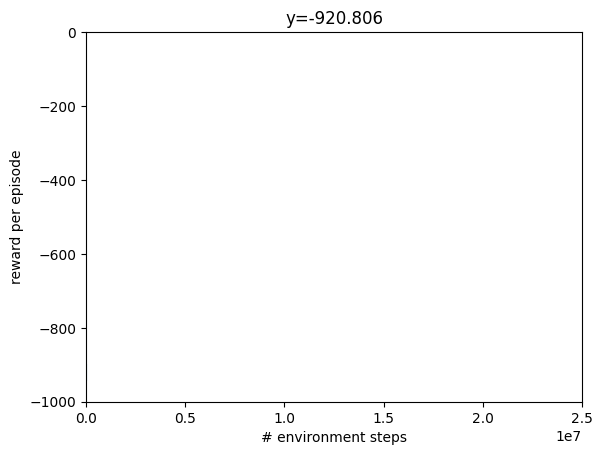

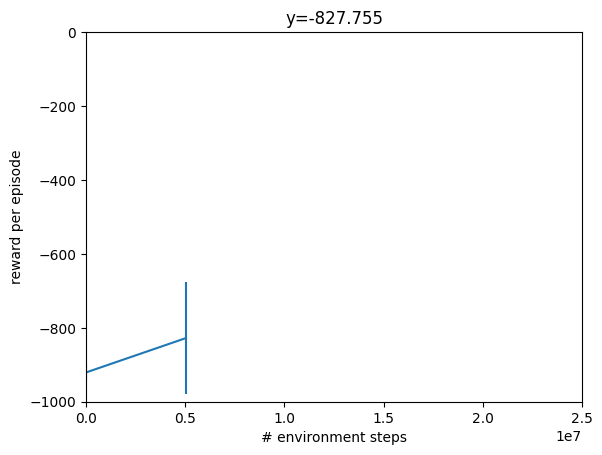

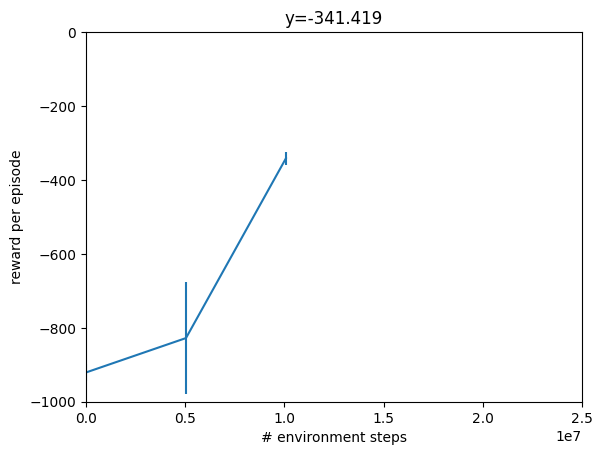

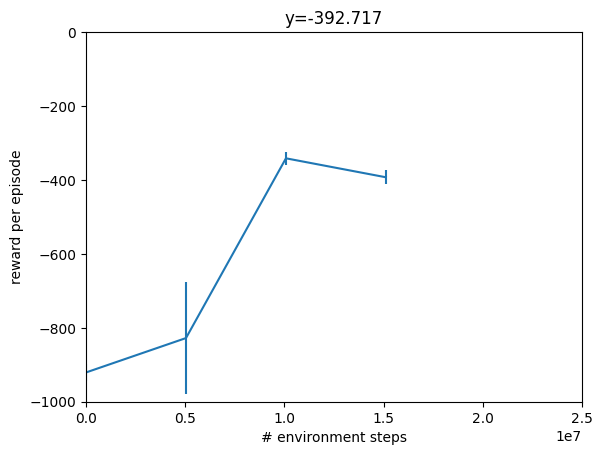

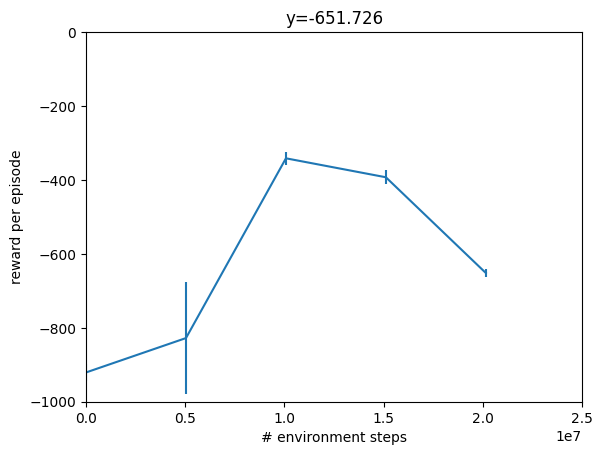

time to jit: 0:00:34.477183
time to train: 0:40:32.621925


In [23]:
import functools
import matplotlib.pyplot as plt

from datetime import datetime
from brax.training.agents.ppo import train as ppo

from brax.training.agents.es import train as es

from evojax.algo import PGPE

train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000,
    num_evals=5,
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=24,
    num_updates_per_batch=8,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-3,
    num_envs=3072,
    batch_size=512,
    seed=0,
)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 0, -1000


def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([-1, train_fn.keywords["num_timesteps"] * 1.25])
    plt.ylim([min_y, max_y])

    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")

    plt.errorbar(x_data, y_data, yerr=ydataerr)
    plt.show()


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
model_path = 'mjx_brax_policy'
model.save_params(model_path, params)

params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 1

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

media.show_video(env.render(rollout[::render_every]), fps=1.0 / env.dt / render_every)

ValueError: The camera "side" does not exist.

In [ ]:
# Copyright 2022 The EvoJAX Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Train an agent to solve the classic CartPole swing up task.

Example command to run this script:
# Train in a harder setup.
python train_cartpole.py --gpu-id=0
# Train in an easy setup.
python train_cartpole.py --gpu-id=0 --easy
# Train a permutation invariant agent in a harder setup.
python train_cartpole.py --gpu-id=0 --pi --max-iter=20000 --pop-size=256 \
--center-lr=0.037 \
--std-lr=0.078 \
--init-std=0.082
# Train a permutation invariant agent in a harder setup with CMA-ES.
python train_cartpole.py --gpu-id=0 --pi --max-iter=20000 --pop-size=256 --cma
"""

import argparse
import os
import shutil
import jax

from evojax import Trainer
from evojax.task.cartpole import CartPoleSwingUp
from evojax.policy import MLPPolicy
from evojax.policy import PermutationInvariantPolicy
from evojax.algo import PGPE
from evojax.algo import CMA
from evojax import util
from evojax.util import get_tensorboard_log_fn


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--pop-size', type=int, default=64, help='NE population size.')
    parser.add_argument(
        '--hidden-size', type=int, default=64, help='Policy hidden size.')
    parser.add_argument(
        '--num-tests', type=int, default=100, help='Number of test rollouts.')
    parser.add_argument(
        '--n-repeats', type=int, default=16, help='Training repetitions.')
    parser.add_argument(
        '--max-iter', type=int, default=1000, help='Max training iterations.')
    parser.add_argument(
        '--test-interval', type=int, default=100, help='Test interval.')
    parser.add_argument(
        '--log-interval', type=int, default=20, help='Logging interval.')
    parser.add_argument(
        '--seed', type=int, default=42, help='Random seed for training.')
    parser.add_argument(
        '--center-lr', type=float, default=0.05, help='Center learning rate.')
    parser.add_argument(
        '--std-lr', type=float, default=0.1, help='Std learning rate.')
    parser.add_argument(
        '--init-std', type=float, default=0.1, help='Initial std.')
    parser.add_argument(
        '--gpu-id', type=str, help='GPU(s) to use.')
    parser.add_argument(
        '--easy', action='store_true', help='Easy mode.')
    parser.add_argument(
        '--pi', action='store_true', help='Permutation invariant policy.')
    parser.add_argument(
        '--cma', action='store_true', help='Training with CMA-ES.')
    parser.add_argument(
        '--debug', action='store_true', help='Debug mode.')
    config, _ = parser.parse_known_args()
    return config


def main(config):
    hard = not config.easy
    log_dir = './log/reaching_{}'.format('hard' if hard else 'easy')
    if not os.path.exists(log_dir):
        os.makedirs(log_dir, exist_ok=True)
    logger = util.create_logger(
        name='Reaching', log_dir=log_dir, debug=config.debug)

    logger.info('EvoJAX Reaching ({}) Demo'.format('hard' if hard else 'easy'))
    logger.info('=' * 30)

    train_task = env # CartPoleSwingUp(test=False, harder=hard)
    test_task = env # CartPoleSwingUp(test=True, harder=hard)


    if config.pi:
        policy = PermutationInvariantPolicy(
            act_dim=test_task.act_shape[0],
            hidden_dim=config.hidden_size,
        )
    else:
        policy = MLPPolicy(
            input_dim=train_task.obs_shape[0],
            hidden_dims=[config.hidden_size] * 2,
            output_dim=train_task.act_shape[0],
        )
    if config.cma:
        solver = CMA(
            pop_size=config.pop_size,
            param_size=policy.num_params,
            init_stdev=config.init_std,
            seed=config.seed,
            logger=logger,
        )
    else:
        solver = PGPE(
            pop_size=config.pop_size,
            param_size=policy.num_params,
            optimizer='adam',
            center_learning_rate=config.center_lr,
            stdev_learning_rate=config.std_lr,
            init_stdev=config.init_std,
            logger=logger,
            seed=config.seed,
        )

    try:
        log_scores_fn = get_tensorboard_log_fn(log_dir=os.path.join(log_dir, "tb_logs"))
    except ImportError as e:
        logger.warning(e)

        def log_scores_fn(i, scores, stage):  # noqa
            pass

    # Train.
    trainer = Trainer(
        policy=policy,
        solver=solver,
        train_task=train_task,
        test_task=test_task,
        max_iter=config.max_iter,
        log_interval=config.log_interval,
        test_interval=config.test_interval,
        n_repeats=config.n_repeats,
        n_evaluations=config.num_tests,
        seed=config.seed,
        log_dir=log_dir,
        logger=logger,
        log_scores_fn=log_scores_fn
    )
    trainer.run(demo_mode=False)

    # Test the final model.
    src_file = os.path.join(log_dir, 'best.npz')
    tar_file = os.path.join(log_dir, 'model.npz')
    shutil.copy(src_file, tar_file)
    trainer.model_dir = log_dir
    trainer.run(demo_mode=True)

    # Generate a GIF to visualize the policy.
    best_params = trainer.solver.best_params[None, :]
    task_reset_fn = jax.jit(test_task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(test_task.step)
    act_fn = jax.jit(policy.get_actions)
    rollout_key = jax.random.PRNGKey(seed=0)[None, :]

    images = []
    task_s = task_reset_fn(rollout_key)
    policy_s = policy_reset_fn(task_s)
    images.append(CartPoleSwingUp.render(task_s, 0))
    done = False
    step = 0
    while not done:
        act, policy_s = act_fn(task_s, best_params, policy_s)
        task_s, r, d = step_fn(task_s, act)
        step += 1
        done = bool(d[0])
        if step % 5 == 0:
            images.append(CartPoleSwingUp.render(task_s, 0))

    gif_file = os.path.join(
        log_dir, 'cartpole_{}.gif'.format('hard' if hard else 'easy'))
    images[0].save(
        gif_file, save_all=True, append_images=images[1:], duration=40, loop=0)
    logger.info('GIF saved to {}'.format(gif_file))


if __name__ == '__main__':
    configs = parse_args()
    if configs.gpu_id is not None:
        os.environ['CUDA_VISIBLE_DEVICES'] = configs.gpu_id
    main(configs)

